[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

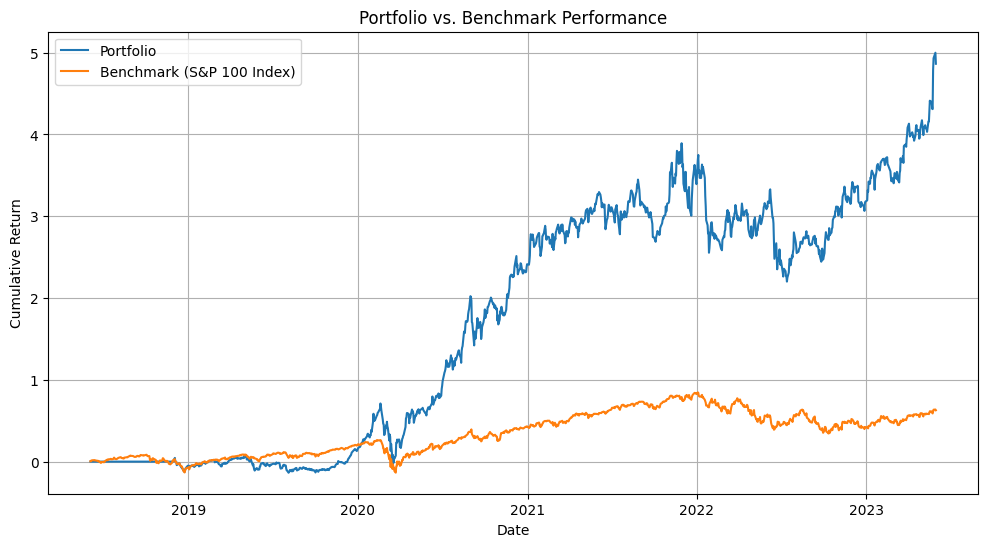

Final Portfolio Value: $5863672.65


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of S&P 100 stock symbols
symbols = [
    "AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "AMD", "AMGN", "AMT", "AMZN",
    "AVGO", "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "BRK.B", "C",
    "CAT", "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CRM", "CSCO", "CVS",
    "CVX", "DE", "DHR", "DIS", "DOW", "DUK", "EMR", "EXC", "F", "FDX", "GD",
    "GE", "GILD", "GM", "GOOG", "GOOGL", "GS", "HD", "HON", "IBM", "INTC",
    "JNJ", "JPM", "KHC", "KO", "LIN", "LLY", "LMT", "LOW", "MA", "MCD",
    "MDLZ", "MDT", "MET", "META", "MMM", "MO", "MRK", "MS", "MSFT", "NEE",
    "NFLX", "NKE", "NVDA", "ORCL", "PEP", "PFE", "PG", "PM", "PYPL", "QCOM",
    "RTX", "SBUX", "SCHW", "SO", "SPG", "T", "TGT", "TMO", "TMUS", "TSLA",
    "TXN", "UNH", "UNP", "UPS", "USB", "V", "VZ", "WFC", "WMT", "XOM"
]
# Define the benchmark symbol (S&P 100 Index - OEX)
benchmark_symbol = "^OEX"

# Define the date range for historical data
start_date = "2018-06-01"
end_date = "2023-06-01"

# Create an empty DataFrame to store historical data
historical_data = pd.DataFrame()

# Fetch historical data for each symbol and store it in the historical_data DataFrame
for symbol in symbols:
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['Symbol'] = symbol  # Add a 'Symbol' column to identify the stock
    historical_data = pd.concat([historical_data, stock_data], ignore_index=False)

# Reset the index to make 'Date' a column
historical_data.reset_index(inplace=True)

# Calculate 6-month returns for each stock
historical_data['6M_Return'] = historical_data.groupby('Symbol')['Adj Close'].pct_change(periods=126)

# Rank stocks by 6-month returns
historical_data['Rank'] = historical_data.groupby('Date')['6M_Return'].rank(ascending=False)

# Select top 10 stocks with the highest 6-month momentum
top_10_momentum_stocks = historical_data[historical_data['Rank'] <= 3]

# Fetch historical data for the benchmark
benchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date)

# Calculate benchmark returns
benchmark_data['Benchmark_Return'] = benchmark_data['Adj Close'].pct_change()

# Create an empty DataFrame to store portfolio performance
portfolio_performance = pd.DataFrame(index=benchmark_data.index)

# Initialize portfolio value and cash balance
initial_balance = 1000000  # Starting with $1,000,000
portfolio_value = initial_balance
cash_balance = initial_balance

# Define the portfolio dictionary to track positions
portfolio = {}

# Define a list to track portfolio values over time
portfolio_values = []

# Define a variable to track the date of the last rebalance
last_rebalance_date = None

# Implement the momentum strategy and backtest
for date, row in benchmark_data.iterrows():
    # Rebalance the portfolio every month
    if last_rebalance_date is None or date.month != last_rebalance_date.month:
        # Sell all existing positions
        for symbol, shares in portfolio.items():
            stock_price = historical_data[(historical_data['Symbol'] == symbol) & (historical_data['Date'] == date)]['Adj Close'].values[0]
            cash_balance += shares * stock_price
        # Clear the portfolio
        portfolio = {}
        # Select the top 10 stocks with the highest momentum
        top_stocks = top_10_momentum_stocks[top_10_momentum_stocks['Date'] == date]['Symbol'].values
        # Buy equal weight positions in the top stocks
        if len(top_stocks) > 0:
          position_size = cash_balance / len(top_stocks)
          for symbol in top_stocks:
            stock_price = historical_data[(historical_data['Symbol'] == symbol) & (historical_data['Date'] == date)]['Adj Close'].values[0]
            shares_to_buy = int(position_size / stock_price)
            portfolio[symbol] = shares_to_buy
            cash_balance -= shares_to_buy * stock_price
            # Update the last rebalance date
            last_rebalance_date = date

    # Calculate the total portfolio value
    total_value = cash_balance
    for symbol, shares in portfolio.items():
        stock_price = historical_data[(historical_data['Symbol'] == symbol) & (historical_data['Date'] == date)]['Adj Close'].values[0]
        total_value += shares * stock_price
    portfolio_values.append(total_value)

# Create a DataFrame for portfolio values
portfolio_performance['Portfolio_Value'] = portfolio_values

# Calculate portfolio returns
portfolio_performance['Portfolio_Return'] = portfolio_performance['Portfolio_Value'].pct_change()

# Calculate cumulative returns
portfolio_performance['Cumulative_Return'] = (portfolio_performance['Portfolio_Return'] + 1).cumprod() - 1
benchmark_data['Cumulative_Return'] = (benchmark_data['Benchmark_Return'] + 1).cumprod() - 1

# Plot the portfolio and benchmark performance
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Cumulative_Return'], label='Portfolio')
plt.plot(benchmark_data.index, benchmark_data['Cumulative_Return'], label='Benchmark (S&P 100 Index)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio vs. Benchmark Performance')
plt.legend()
plt.grid(True)
plt.show()

# Print the final portfolio value
final_portfolio_value = portfolio_performance['Portfolio_Value'].iloc[-1]
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

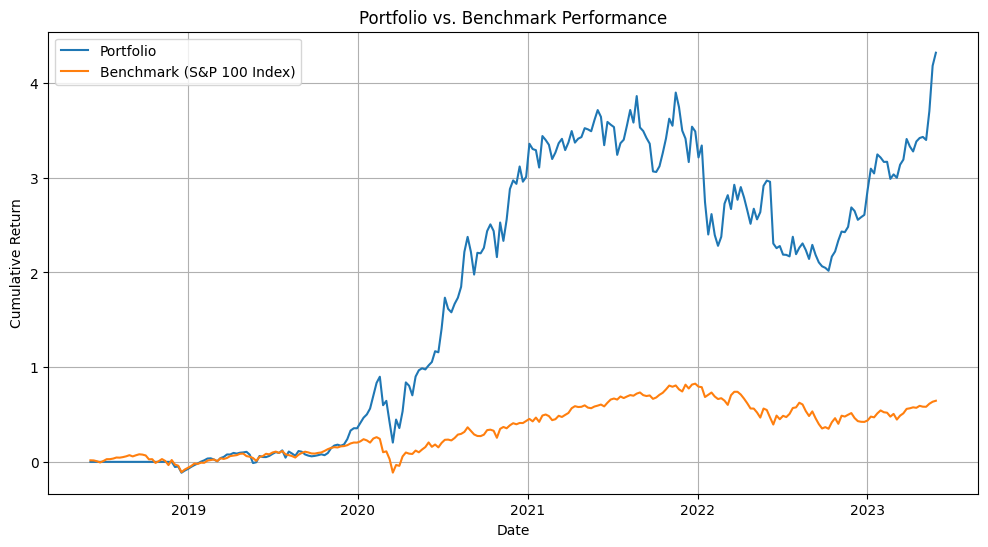

Final Portfolio Value: $5320564.64


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of S&P 100 stock symbols
symbols = [
    "AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "AMD", "AMGN", "AMT", "AMZN",
    "AVGO", "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "BRK-B", "C",
    "CAT", "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CRM", "CSCO", "CVS",
    "CVX", "DE", "DHR", "DIS", "DOW", "DUK", "EMR", "EXC", "F", "FDX", "GD",
    "GE", "GILD", "GM", "GOOG", "GOOGL", "GS", "HD", "HON", "IBM", "INTC",
    "JNJ", "JPM", "KHC", "KO", "LIN", "LLY", "LMT", "LOW", "MA", "MCD",
    "MDLZ", "MDT", "MET", "META", "MMM", "MO", "MRK", "MS", "MSFT", "NEE",
    "NFLX", "NKE", "NVDA", "ORCL", "PEP", "PFE", "PG", "PM", "PYPL", "QCOM",
    "RTX", "SBUX", "SCHW", "SO", "SPG", "T", "TGT", "TMO", "TMUS", "TSLA",
    "TXN", "UNH", "UNP", "UPS", "USB", "V", "VZ", "WFC", "WMT", "XOM"
]

# Define the benchmark symbol (S&P 100 Index - OEX)
benchmark_symbol = "^OEX"

# Define the date range for historical data
start_date = "2018-06-01"
end_date = "2023-06-01"

# Create an empty DataFrame to store historical data
historical_data = pd.DataFrame()

# Fetch historical data for each symbol and store it in the historical_data DataFrame
for symbol in symbols:
    stock_data = yf.download(symbol, start=start_date, end=end_date, interval="1wk")  # Weekly data
    stock_data['Symbol'] = symbol  # Add a 'Symbol' column to identify the stock
    historical_data = pd.concat([historical_data, stock_data], ignore_index=False)

# Reset the index to make 'Date' a column
historical_data.reset_index(inplace=True)

# Calculate 26-week returns for each stock
historical_data['26W_Return'] = historical_data.groupby('Symbol')['Adj Close'].pct_change(periods=26)

# Rank stocks by 26-week returns
historical_data['Rank'] = historical_data.groupby('Date')['26W_Return'].rank(ascending=False)

# Select top 10 stocks with the highest 26-week momentum
top_10_momentum_stocks = historical_data[historical_data['Rank'] <= 3]

# Fetch historical data for the benchmark
benchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date, interval="1wk")

# Calculate benchmark returns
benchmark_data['Benchmark_Return'] = benchmark_data['Adj Close'].pct_change()

# Create an empty DataFrame to store portfolio performance
portfolio_performance = pd.DataFrame(index=benchmark_data.index)

# Initialize portfolio value and cash balance
initial_balance = 1000000  # Starting with $1,000,000
portfolio_value = initial_balance
cash_balance = initial_balance

# Define the portfolio dictionary to track positions
portfolio = {}

# Define a list to track portfolio values over time
portfolio_values = []

# Define a variable to track the date of the last rebalance
last_rebalance_date = None

# Implement the momentum strategy and backtest
for date, row in benchmark_data.iterrows():
    # Rebalance the portfolio every month
    if last_rebalance_date is None or date.month != last_rebalance_date.month:
        # Sell all existing positions
        for symbol, shares in portfolio.items():
            stock_price = historical_data[(historical_data['Symbol'] == symbol) & (historical_data['Date'] == date)]['Adj Close'].values[0]
            cash_balance += shares * stock_price
        # Clear the portfolio
        portfolio = {}
        # Select the top 10 stocks with the highest momentum
        top_stocks = top_10_momentum_stocks[top_10_momentum_stocks['Date'] == date]['Symbol'].values
        # Buy equal weight positions in the top stocks
        if len(top_stocks) > 0:
            position_size = cash_balance / len(top_stocks)
            for symbol in top_stocks:
                stock_price = historical_data[(historical_data['Symbol'] == symbol) & (historical_data['Date'] == date)]['Adj Close'].values[0]
                shares_to_buy = int(position_size / stock_price)
                portfolio[symbol] = shares_to_buy
                cash_balance -= shares_to_buy * stock_price
            # Update the last rebalance date
            last_rebalance_date = date

    # Calculate the total portfolio value
    total_value = cash_balance
    for symbol, shares in portfolio.items():
        stock_price = historical_data[(historical_data['Symbol'] == symbol) & (historical_data['Date'] == date)]['Adj Close'].values[0]
        total_value += shares * stock_price
    portfolio_values.append(total_value)

# Create a DataFrame for portfolio values
portfolio_performance['Portfolio_Value'] = portfolio_values

# Calculate portfolio returns
portfolio_performance['Portfolio_Return'] = portfolio_performance['Portfolio_Value'].pct_change()

# Calculate cumulative returns
portfolio_performance['Cumulative_Return'] = (portfolio_performance['Portfolio_Return'] + 1).cumprod() - 1
benchmark_data['Cumulative_Return'] = (benchmark_data['Benchmark_Return'] + 1).cumprod() - 1

# Plot the portfolio and benchmark performance
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Cumulative_Return'], label='Portfolio')
plt.plot(benchmark_data.index, benchmark_data['Cumulative_Return'], label='Benchmark (S&P 100 Index)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio vs. Benchmark Performance')
plt.legend()
plt.grid(True)
plt.show()

# Print the final portfolio value
final_portfolio_value = portfolio_performance['Portfolio_Value'].iloc[-1]
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
